# Setup

Importanto alguns módulos necessários

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

c:\Users\jean_\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\jean_\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\jean_\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

Verifique se existe uma GPU disponível

In [4]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


**Gymnasium**

In [5]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

In [6]:
import gymnasium as gym
import numpy as np

In [7]:
# extra code – creates a little function to render and plot an environment
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

In [8]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

Vamos começar criando um ambiente LunarLander-v2:

In [9]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

As entradas são de 8 dimensões

In [10]:
env.observation_space

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

In [11]:
obs, info = env.reset(seed=42)
obs

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

Aqui [source code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/box2d/lunar_lander.py), podemos ver que cada observação 8D (x, y, h, v, a, w, l, r) corresponde a:

* x,y: as coordenadas da nave espacial. Ele começa em um local aleatório próximo a (0, 1.4) e deve pousar próximo ao alvo em (0, 0).
* h,v: a velocidade horizontal e vertical da nave espacial. Começa com uma pequena velocidade aleatória.
* a,w: o ângulo e a velocidade angular da nave espacial.
* l,r: se a perna esquerda ou direita toca o chão (1,0) ou não (0,0).


O espaço de ação é discreto, com 4 ações possíveis:

In [12]:
env.action_space

Discrete(4)

Veja [LunarLander-v2's description](https://gymnasium.farama.org/environments/box2d/lunar_lander/), essas ações são:
* fazer nada
* disparar motor de orientação à esquerda
* motor principal de ignição
* disparar motor de orientação à direita

Vamos criar uma rede de políticas simples com 4 neurônios de saída (um por ação possível):

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(n_outputs, activation="softmax"),
])

c:\Users\jean_\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Observe que estamos usando a função de ativação softmax na camada de saída, em vez da função de ativação sigmóide como fizemos para o ambiente CartPole-v1. Isso ocorre porque tínhamos apenas duas ações possíveis para o ambiente CartPole-v1, portanto, um modelo de classificação binária funcionou bem. Entretanto, como agora temos mais de duas ações possíveis, precisamos de um modelo de classificação multiclasse.

A seguir, vamos reutilizar as funções play_one_step() e play_multiple_episodes() que definimos, mas vamos apenas ajustar a função play_one_step() para levar em conta o fato de que o modelo agora é um modelo de classificação multiclasse em vez de um modelo de classificação binária. Também ajustaremos a função play_multiple_episodes() para chamar nossa função play_one_step() ajustada em vez da função original, e adicionaremos uma grande penalidade se a nave espacial não pousar (ou bater) antes de um número máximo de etapas.

In [14]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info, truncated = env.step(action[0, 0].numpy())
    return obs, reward, done, truncated, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = lander_play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Manteremos exatamente as mesmas funções `discount_rewards()` e `discount_and_normalize_rewards()` de antes:

In [15]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Agora vamos definir alguns hiperparâmetros:

In [24]:
n_iterations = 60
n_episodes_per_update = 16
n_max_steps = 1000
discount_factor = 0.99

Novamente, como o modelo é um modelo de classificação multiclasse, devemos usar a categorical cross-entropy em vez da binary cross-entropy. Além disso, como a função lander_play_one_step() define os targets como índices de classe em vez de probabilidades de classe, devemos usar a função de perda sparse_categorical_crossentropy():

In [25]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

Treinamento do modelo

In [26]:
env.reset(seed=42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean reward: {mean_reward:.1f}  ", end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 60/60, mean reward: 10.1    

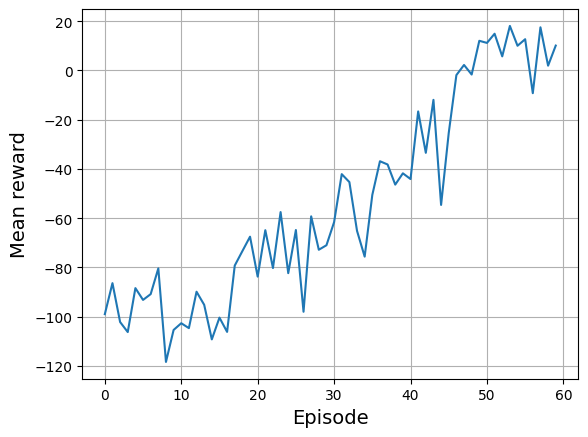

In [27]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [28]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
        if done or truncated:
            break
    env.close()
    return frames

In [29]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

Você pode tentar treiná-lo por mais tempo e/ou ajustar os hiperparâmetros.

**Referência**

[Hands-on ML with Scikit-Learn, Keras & TF by Aurelien Geron](https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb)